In [ ]:
%load_ext autoreload
%autoreload 2
#%env CUDA_VISIBLE_DEVICES=3

#### Download packages if in Google Colab

In [ ]:
colab_requirements = [
    "pip install librosa",
    "pip install noisereduce",
    "pip install soundfile",

]

import sys, subprocess

def run_subprocess_command(cmd):
    # run the command
    process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
    # print the output
    for line in process.stdout:
        print(line.decode().strip())

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    for i in colab_requirements:
        run_subprocess_command(i)

# Test noise reduction algorithm and view steps of algorithm

In [ ]:
import IPython
from scipy.io import wavfile
import noisereduce as nr
import soundfile as sf
from noisereduce.generate_noise import band_limited_noise
import matplotlib.pyplot as plt
import urllib.request
import numpy as np
import io
import librosa
%matplotlib inline

### Load data

In [ ]:
from IPython.display import Audio
file_path = "/content/audio1.dat.unknown"
data,rate = librosa.load(file_path,sr = None)
Audio(data = data,rate = rate)

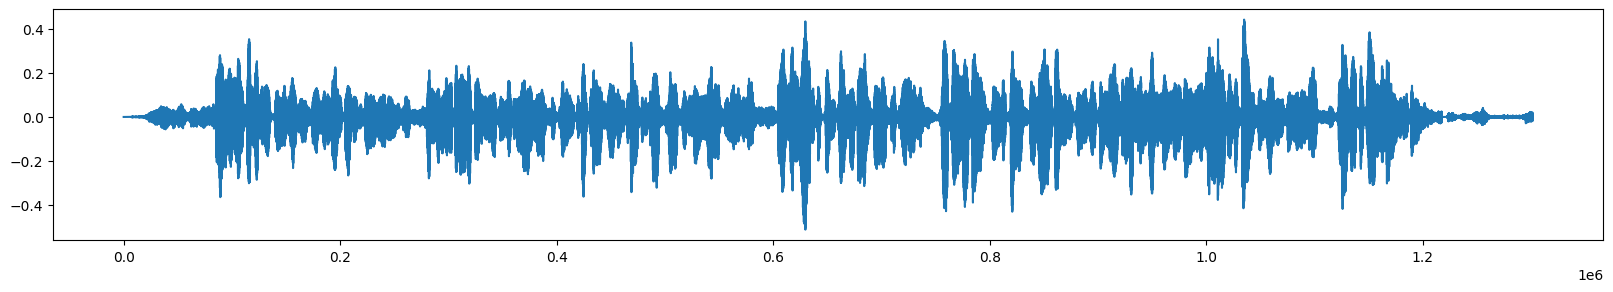

In [ ]:
fig, ax = plt.subplots(figsize = (20,3))
ax.plot(data)

### add noise

In [ ]:
noise_len = 2
noise = band_limited_noise(min_freq=2000, max_freq = 10000, samples=len(data), samplerate=rate)*10
noise_clip = noise[:rate*noise_len]
audio_clip_band_limited = data+noise

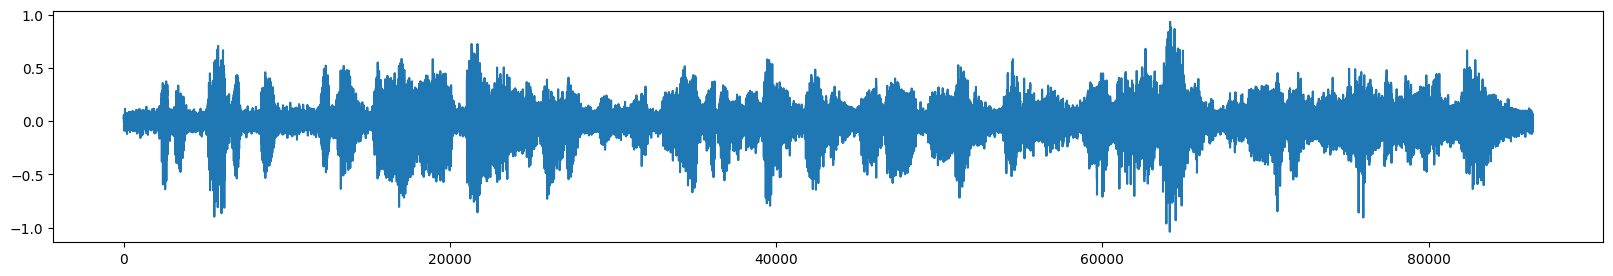

In [ ]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(audio_clip_band_limited)

In [ ]:
IPython.display.Audio(data=audio_clip_band_limited, rate=rate)

### Stationary remove noise

In [ ]:
reduced_noise = nr.reduce_noise(y = audio_clip_band_limited, sr=rate, n_std_thresh_stationary=2.0,stationary=True)

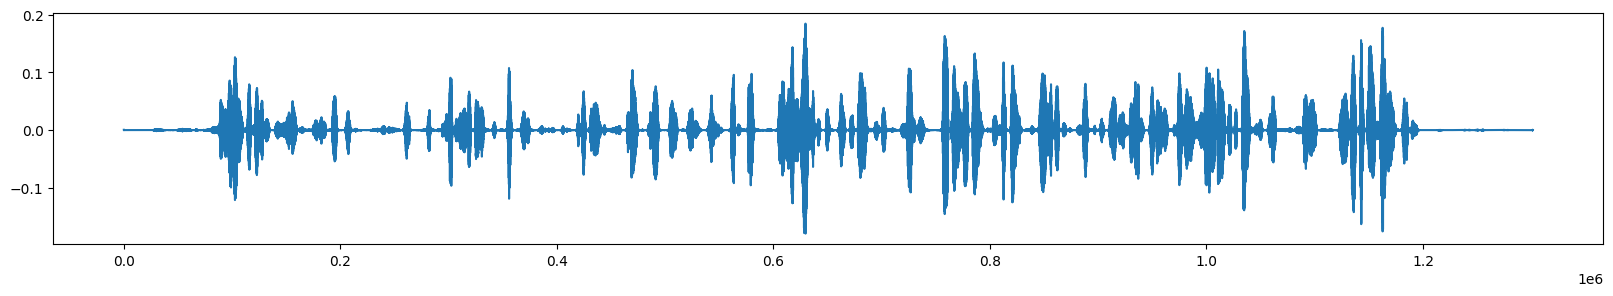

In [ ]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(reduced_noise)

In [ ]:
IPython.display.Audio(data=reduced_noise, rate=rate)

### Non-stationary noise reduction

In [ ]:
reduced_noise = nr.reduce_noise(y = audio_clip_band_limited, sr=rate, thresh_n_mult_nonstationary=2,stationary=False)

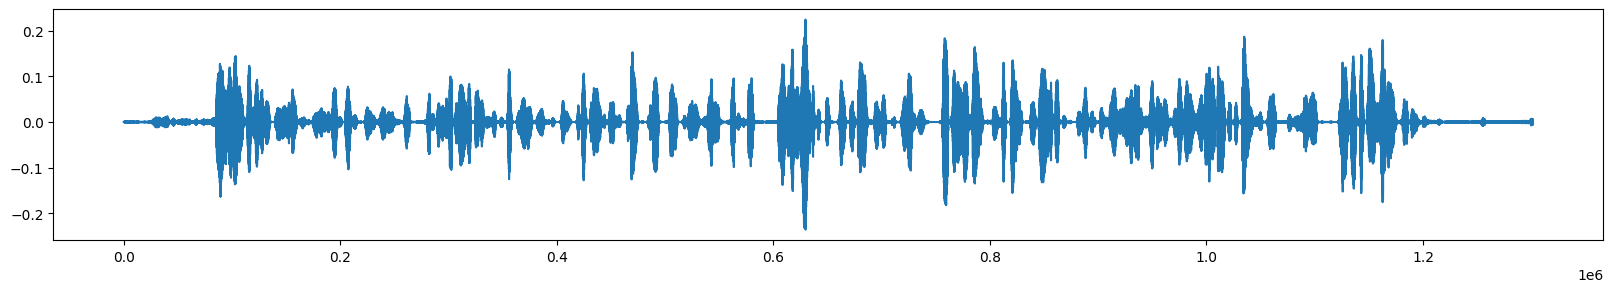

In [ ]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(reduced_noise)

In [ ]:
S = librosa.feature.melspectrogram(y=reduced_noise, sr=rate, n_mels=128,
                                    fmax=8000)

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

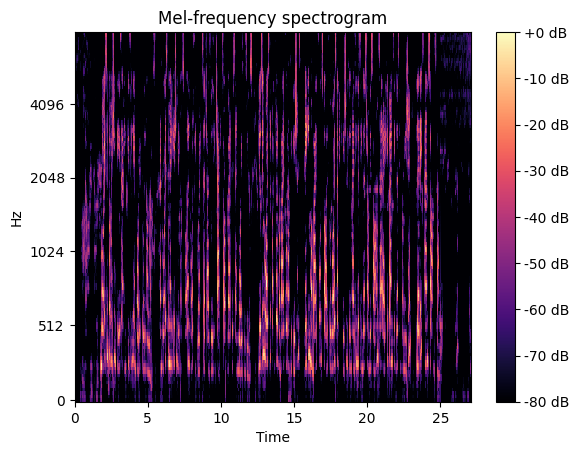

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=rate,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

In [ ]:
import librosa
for n_mfcc in [10, 13, 16, 20]:
    mfccs = librosa.feature.mfcc(y=reduced_noise, sr=rate, n_mfcc=n_mfcc)
    print(f"MFCCs with n_mfcc={n_mfcc}: {mfccs.shape}")


MFCCs with n_mfcc=10: (10, 2543)
MFCCs with n_mfcc=13: (13, 2543)
MFCCs with n_mfcc=16: (16, 2543)
MFCCs with n_mfcc=20: (20, 2543)


[[-652.49112937 -649.03710428 -645.61036526 ... -569.80159442
  -577.32546761 -592.07743412]
 [  -0.69668979   -3.71739189   -6.36142708 ...  -59.06311922
   -63.83693658  -57.33490955]]
[-560.03113954   46.69559709]


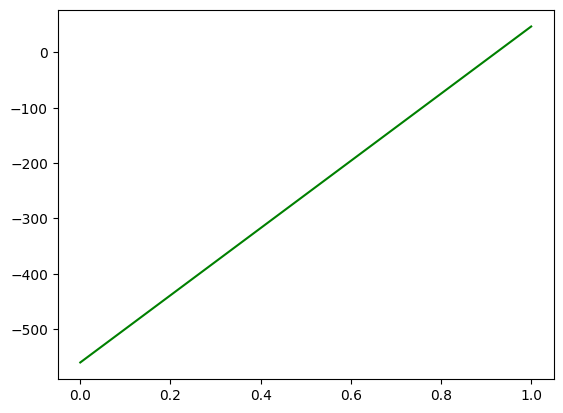

In [ ]:
mfcc = librosa.feature.mfcc(y=reduced_noise, sr=rate,n_mfcc = 2)
print(mfcc)
mfccScaled = np.mean(mfcc.T, axis=0)
print(mfccScaled)
plt.plot(mfccScaled, 'g')
plt.show()

In [ ]:
import numpy as np
import librosa
mfcc = librosa.feature.mfcc(y=reduced_noise, sr=rate,n_mfcc = 10)
csv_file_path = "mfcc_data.csv"
np.savetxt(csv_file_path, mfcc, delimiter=",")
print(f"MFCCs saved to {csv_file_path}")

MFCCs saved to mfcc_data.csv


In [ ]:
import pandas as pd
data = pd.read_csv("/content/mfcc_data.csv",header = 0)
data.head()

In [ ]:
data.shape

In [ ]:

import numpy as np
import pandas as pd

# Assuming your data is in a DataFrame called 'df' with columns -5.824... and -5.256...
# Extract the numerical values from the DataFrame
data1 = data.iloc[:, 1:].values  # Assuming the first column contains non-numeric data

# Standardize the data (optional but recommended)
mean_vals = np.mean(data1, axis=0)
std_dev = np.std(data1, axis=0)
standardized_data = (data1 - mean_vals) / std_dev

# Calculate the covariance matrix
cov_matrix = np.cov(standardized_data, rowvar=False)

# Calculate the eigenvectors and eigenvalues
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

# Sort eigenvectors by decreasing eigenvalues
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvectors_sorted = eigenvectors[:, sorted_indices]

# Choose the number of components
n_components = 2
selected_components = eigenvectors_sorted[:, :n_components]

# Project the data onto the selected components
data_pca = np.dot(standardized_data, selected_components)

# Create a new DataFrame with reduced dimensions
columns_pca = [f'PC{i+1}' for i in range(n_components)]
df_pca = pd.DataFrame(data_pca, columns=columns_pca)

# Concatenate the non-numeric column with the reduced dimensions
result_df = pd.concat([data.iloc[:, :1], df_pca], axis=1)

# Display the resulting DataFrame
print(result_df)


##CNN



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
num_mfcc_coefficients = 13
num_frames = 100
model = models.Sequential([
    layers.Reshape((num_frames, num_mfcc_coefficients, 1), input_shape=(num_frames, num_mfcc_coefficients)),
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
mfcc_data = pd.read_csv('/content/mfcc_data.csv')
X_train, X_val, y_train, y_val = train_test_split(mfcc_data, ground_truth_data, test_size=0.2, random_state=42)

## A more difficult example

In [ ]:
from IPython.display import Audio
file_path = "/content/Jungkook-(정국)-Standing-Next-To-You(musicdownload.cc).mp3"
data1,rate = librosa.load(file_path,sr = None)
Audio(data = data1,rate = rate)

In [ ]:
fig, ax = plt.subplots(figsize=(20,4))
ax.plot(data1)

In [ ]:
IPython.display.Audio(data=data1, rate=rate)

### add noise to data

In [ ]:
snr = 2
noise_clip = data1/snr
audio_clip_cafe = data1 + noise_clip

### plot noisy data

In [ ]:
fig, ax = plt.subplots(figsize=(20,4))
ax.plot(audio_clip_cafe)
IPython.display.Audio(data=audio_clip_cafe, rate=rate)

### Stationary remove noise

In [ ]:
reduced_noise = nr.reduce_noise(y = audio_clip_cafe, sr=rate, y_noise = noise_clip, n_std_thresh_stationary=1.5,stationary=True)

In [ ]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(audio_clip_cafe)
ax.plot(reduced_noise)

In [ ]:
IPython.display.Audio(data=reduced_noise, rate=rate)

### Non-stationary noise reduction

In [ ]:
reduced_noise = nr.reduce_noise(y = audio_clip_cafe, sr=rate, thresh_n_mult_nonstationary=2,stationary=False)

In [ ]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(audio_clip_cafe)
ax.plot(reduced_noise, alpha = 1)
IPython.display.Audio(data=reduced_noise, rate=rate)

In [ ]:
IPython.display.Audio(data=reduced_noise, rate=rate)

### ensure that noise reduction does not cause distortion when prop_decrease == 0

In [ ]:
noise_reduced = nr.reduce_noise(y=data, sr=rate, prop_decrease=0, stationary=False)

In [ ]:
fig, axs = plt.subplots(nrows=2, figsize=(20,6))
axs[0].plot(data[3000:5000])
axs[0].plot(noise_reduced[3000:5000])
axs[1].plot(data)
axs[1].plot(noise_reduced)

In [ ]:
noise_reduced = nr.reduce_noise(y=data, sr=rate, prop_decrease=0, stationary=False)

In [ ]:
fig, axs = plt.subplots(nrows=2, figsize=(20,6))
axs[0].plot(data[3000:5000])
axs[0].plot(noise_reduced[3000:5000])
axs[1].plot(data)
axs[1].plot(noise_reduced)

### Reduce noise over batches in parallel on long signal

In [ ]:
long_data = np.tile(data, 10)
len(long_data)/rate

In [ ]:
fig, ax = plt.subplots(figsize=(20,4))
ax.plot(long_data)

In [ ]:
noise = band_limited_noise(min_freq=2000, max_freq = 12000, samples=len(long_data), samplerate=rate)*10
audio_clip_band_limited = long_data+noise

In [ ]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(audio_clip_band_limited)

In [ ]:
reduced_noise = nr.reduce_noise(
    y=audio_clip_band_limited,
    sr=rate,
    thresh_n_mult_nonstationary=2,
    stationary=False,
    n_jobs=2,
)

In [ ]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(audio_clip_band_limited)
ax.plot(reduced_noise)

In [ ]:
reduced_noise = nr.reduce_noise(
    y=audio_clip_band_limited,
    sr=rate,
    thresh_n_mult_nonstationary=2,
    stationary=True,
    n_jobs=2,
)

In [ ]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(audio_clip_band_limited)
ax.plot(reduced_noise)

### Reduce noise on only a subset of a long clip

In [ ]:
from noisereduce.noisereduce import SpectralGateStationary

In [ ]:
sg = SpectralGateStationary(
    y = data,
    sr = rate,
    y_noise=None,
    prop_decrease=1.0,
    time_constant_s=2.0,
    freq_mask_smooth_hz=500,
    time_mask_smooth_ms=50,
    n_std_thresh_stationary=1.5,
    tmp_folder=None,
    chunk_size=600000,
    padding=30000,
    n_fft=1024,
    win_length=None,
    hop_length=None,
    clip_noise_stationary=True,
    use_tqdm=False,
    n_jobs=1,
)

In [ ]:
subset_noise_reduce = sg.get_traces(start_frame = 10000, end_frame = 20000)

In [ ]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(subset_noise_reduce)

## Multichannel noise

In [ ]:
audio_clip_cafe_2_channel = np.vstack([audio_clip_cafe, audio_clip_cafe])
audio_clip_cafe_2_channel.shape

In [ ]:
reduced_noise = nr.reduce_noise(y = audio_clip_cafe_2_channel, sr=rate, n_std_thresh_stationary=1.5,stationary=True)

In [ ]:
reduced_noise.shape

In [ ]:
fig, axs = plt.subplots(nrows= 2, figsize=(20,5))
axs[0].plot(audio_clip_cafe_2_channel[0])
axs[1].plot(audio_clip_cafe_2_channel[1])

axs[0].plot(reduced_noise[0])
axs[1].plot(reduced_noise[1])

In [ ]:
IPython.display.Audio(data=reduced_noise, rate=rate)

In [ ]:
reduced_noise = nr.reduce_noise(y = audio_clip_cafe, sr=rate, thresh_n_mult_nonstationary=2,stationary=False)

In [ ]:
reduced_noise.shape

In [ ]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(audio_clip_cafe)
ax.plot(reduced_noise, alpha = 1)
IPython.display.Audio(data=reduced_noise, rate=rate)

[https://www.worldscientific.com/doi/pdf/10.1142/S2196888822500300](https://www.worldscientific.com/doi/pdf/10.1142/S2196888822500300)
- for referance(cnn,lstm ->model training)
